**Hypothesis 2:** "Periods of high employment (PAYEMS) correspond with higher Gross Domestic Product (GDP) growth rates."

**Rationale:** Employment is often a leading indicator of economic growth, as more people working typically leads to higher production and consumption.

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project='fred-employment-initial-test')

# Your query string
query = """
SELECT *
FROM `fred-employment-initial-test.fred_data.fred_data_withnotes`
WHERE series_id IN ('PAYEMS', 'GDP')
"""

# Run the query
query_job = client.query(query)

# Convert the query results to a pandas DataFrame
data = query_job.to_dataframe()

# Display the first few rows
print(data.head())

                       date series_id    value                         title  \
0 1939-01-01 00:00:00+00:00    PAYEMS  29923.0  All Employees, Total Nonfarm   
1 1939-02-01 00:00:00+00:00    PAYEMS  30100.0  All Employees, Total Nonfarm   
2 1939-03-01 00:00:00+00:00    PAYEMS  30280.0  All Employees, Total Nonfarm   
3 1939-04-01 00:00:00+00:00    PAYEMS  30094.0  All Employees, Total Nonfarm   
4 1939-05-01 00:00:00+00:00    PAYEMS  30299.0  All Employees, Total Nonfarm   

                  units frequency  seasonal_adjustment  \
0  Thousands of Persons   Monthly  Seasonally Adjusted   
1  Thousands of Persons   Monthly  Seasonally Adjusted   
2  Thousands of Persons   Monthly  Seasonally Adjusted   
3  Thousands of Persons   Monthly  Seasonally Adjusted   
4  Thousands of Persons   Monthly  Seasonally Adjusted   

             last_updated                                              notes  
0  2024-08-02 07:48:01-05  All Employees: Total Nonfarm, commonly known a...  
1  2024-08-0

In [ ]:
import pandas_datareader.data as web

# Define the start and end dates
start = '1947-01-01'  # Start date (you can adjust this)
end = '2024-12-31'    # End date (you can adjust this)

# Fetch GDP data
gdp_data = web.DataReader('GDP', 'fred', start, end)
print(gdp_data.head())

                GDP
DATE               
1947-01-01  243.164
1947-04-01  245.968
1947-07-01  249.585
1947-10-01  259.745
1948-01-01  265.742


Convert the data column in gdp_data to datetime format:

In [ ]:
import pandas as pd
gdp_data = gdp_data.reset_index().rename(columns={'DATE': 'date'})
gdp_data['date'] = pd.to_datetime(gdp_data['date'])

Making sure that the date column in payroll_data is in datetime format:

In [ ]:
# Assuming you're pulling payroll data similarly to GDP data
payroll_data = web.DataReader('PAYEMS', 'fred', start, end)

# Now you can convert the 'date' column to datetime
payroll_data = payroll_data.reset_index().rename(columns={'DATE': 'date'})
payroll_data['date'] = pd.to_datetime(payroll_data['date'])

# Continue with your operations on payroll_data

Addressing Mismatch in timezone information in date columns + Merging Data:

In [ ]:
# Remove timezone information from the date columns in both DataFrames
payroll_data['date'] = pd.to_datetime(payroll_data['date']).dt.tz_localize(None)
gdp_data['date'] = pd.to_datetime(gdp_data['date']).dt.tz_localize(None)

# Now merge the DataFrames
merged_data = pd.merge(payroll_data[['date', 'PAYEMS']], gdp_data, on='date')
print(merged_data.head())

        date  PAYEMS      GDP
0 1947-01-01   43535  243.164
1 1947-04-01   43499  245.968
2 1947-07-01   43743  249.585
3 1947-10-01   44411  259.745
4 1948-01-01   44679  265.742


**1. Plotting the Data**

In [ ]:
!pip install mplcyberpunk

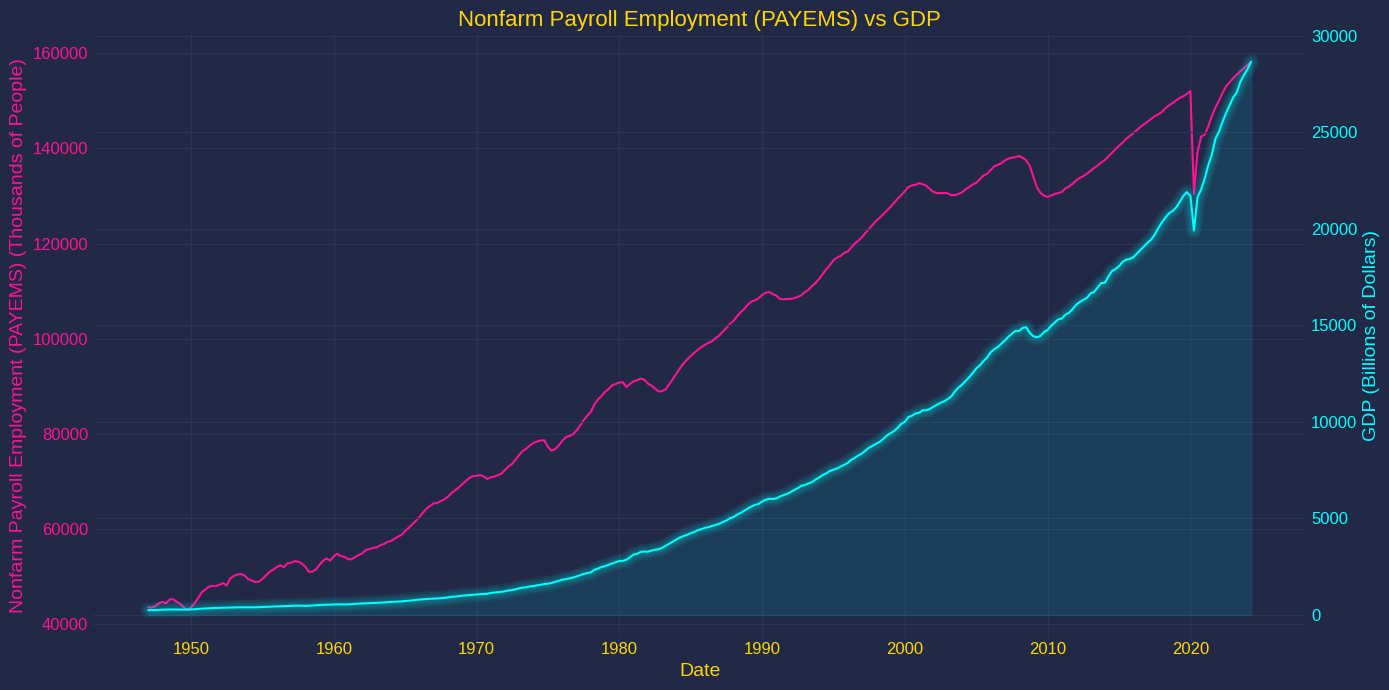

In [ ]:
import matplotlib.pyplot as plt
import mplcyberpunk
import pandas as pd

# Use the Cyberpunk style
plt.style.use("cyberpunk")

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Nonfarm Payroll Employment (PAYEMS) on the first axis
ax1.plot(merged_data['date'], merged_data['PAYEMS'], color='#ff1493', label='Nonfarm Payroll Employment (PAYEMS)')
ax1.set_xlabel('Date', fontsize=14, color='#ffd700')
ax1.set_ylabel('Nonfarm Payroll Employment (PAYEMS) (Thousands of People)', color='#ff1493', fontsize=14)
ax1.tick_params(axis='y', labelcolor='#ff1493', labelsize=12)
ax1.tick_params(axis='x', labelcolor='#ffd700', labelsize=12)

# Create the second y-axis for GDP
ax2 = ax1.twinx()
ax2.plot(merged_data['date'], merged_data['GDP'], color='#00ffff', label='GDP')
ax2.set_ylabel('GDP (Billions of Dollars)', color='#00ffff', fontsize=14)
ax2.tick_params(axis='y', labelcolor='#00ffff', labelsize=12)

# Set the title and add glow effects
plt.title('Nonfarm Payroll Employment (PAYEMS) vs GDP', fontsize=16, color='#ffd700')
mplcyberpunk.add_glow_effects()

# Adjust layout to ensure labels and title are well positioned
plt.tight_layout()

# Show the plot
plt.show()

**2. Correlation Analysis**

In [ ]:
import pandas as pd
from IPython.display import HTML

# Assuming 'merged_data' already has the necessary columns from your previous steps
# Calculate the Pearson correlation coefficient
correlation = merged_data['PAYEMS'].corr(merged_data['GDP'])

# Display the result with Cyberpunk style
HTML(f"""
<div style="background-color:#0d0f12; padding:10px; border-radius:10px; width: fit-content; margin: 10px auto;">
    <p style="color:#ff1493; font-size:20px; font-family: 'Courier New', Courier, monospace;">
        <strong>Pearson Correlation Coefficient:</strong>
        <span style="color:#00ffff;">{correlation:.5f}</span>
    </p>
</div>
""")

The Pearson correlation coefficient of approximately 0.915 indicates a strong positive linear relationship between Nonfarm Payroll Employment (PAYEMS) and GDP. This means that as PAYEMS increases, GDP also tends to increase, and vice versa. This result supports the hypothesis that high employment levels (measured by PAYEMS) are associated with higher GDP.

**3. Linear Regression Analysis**

In [ ]:
import statsmodels.api as sm

# Prepare the data
X = merged_data['PAYEMS']
y = merged_data['GDP']
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary
summary_html = model.summary().as_html()

In [ ]:
from IPython.display import HTML

# Custom CSS for Cyberpunk theme
cyberpunk_css = """
<style>
    body {
        background-color: #0a0a0a;
        color: #00ffcc;
        font-family: 'Courier New', Courier, monospace;
    }
    table {
        width: 100%;
        border-collapse: collapse;
    }
    th, td {
        border: 1px solid #ff007f;
        padding: 8px;
        text-align: center;
    }
    th {
        background-color: #002b36;
        color: #00ffcc;
    }
    tr:nth-child(even) {
        background-color: #003b46;
    }
    caption {
        caption-side: top;
        text-align: center;
        color: #ff007f;
        font-weight: bold;
    }
</style>
"""

# Combine the CSS with the summary HTML
styled_summary_html = cyberpunk_css + summary_html

# Display the styled summary
HTML(styled_summary_html)

**R-squared: 0.836**
This indicates that approximately 83.6% of the variation in GDP can be explained by changes in PAYEMS (Nonfarm Payroll Employment). This is a high value, indicating a strong relationship between the two variables.

**PAYEMS Coefficient: 0.1947**
This suggests that for every thousand increase in PAYEMS, GDP is expected to increase by 0.1947 units (likely billions of dollars, depending on the units of GDP).

**P-value for PAYEMS: 0.000**
The p-value is highly significant, indicating that the relationship between PAYEMS and GDP is statistically significant.

**Constant: -11,720**
The negative constant indicates that the regression line intersects the GDP axis below zero, which is more of a mathematical artifact since GDP cannot be negative in reality.

**Interpretation:**
These results strongly support the hypothesis that periods of high employment (as measured by PAYEMS) are associated with higher GDP growth rates. The high R-squared value and the significant p-value indicate a robust model.


**Scatter Plot:**

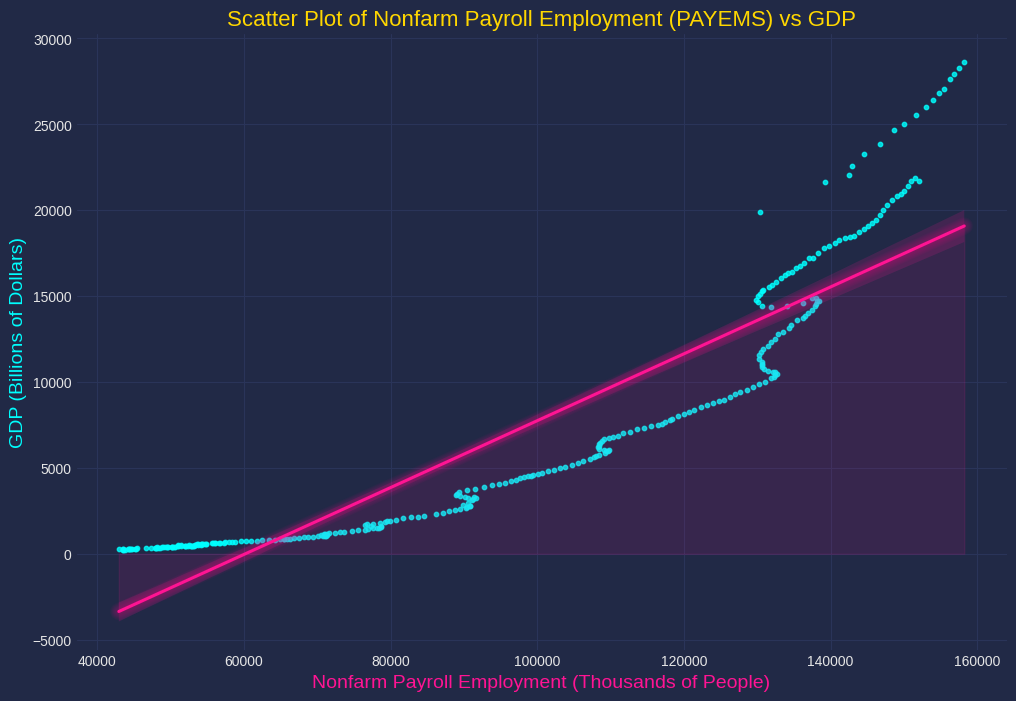

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

# Apply the Cyberpunk style
plt.style.use("cyberpunk")

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.regplot(x='PAYEMS', y='GDP', data=merged_data, scatter_kws={'s': 10, 'color': '#00ffff'}, line_kws={'color': '#ff1493'})

# Set the labels and title with Cyberpunk colors
plt.xlabel('Nonfarm Payroll Employment (Thousands of People)', fontsize=14, color='#ff1493')
plt.ylabel('GDP (Billions of Dollars)', fontsize=14, color='#00ffff')
plt.title('Scatter Plot of Nonfarm Payroll Employment (PAYEMS) vs GDP', fontsize=16, color='#ffd700')

# Add some glow to the plot
mplcyberpunk.add_glow_effects()

# Show the plot
plt.show()

**Positive Correlation:** There is a strong positive correlation between PAYEMS and GDP, as evidenced by the scatter plot. This means that as nonfarm payroll employment increases, GDP also tends to increase, which is aligned with the economic theory that higher employment leads to greater production and consumption.

**Non-linear Relationship:** While there is a general trend upwards, the scatter plot indicates that the relationship between PAYEMS and GDP is not perfectly linear. The curvature of the data points, especially at higher employment levels, suggests that the growth in GDP may accelerate as employment increases, particularly in recent years.

**Outliers or Non-linearity:** There are points that deviate from the regression line, particularly towards the higher end of the PAYEMS values. These deviations may suggest the presence of outliers or indicate non-linear behavior that could warrant further investigation to understand the underlying causes.

**Good Fit Overall:** The linear regression line fits the data fairly well, capturing the general trend between PAYEMS and GDP. The high R-squared value supports the hypothesis that periods of high employment are associated with higher GDP growth rates. However, the non-linear aspects highlighted by the scatter plot suggest that a more complex model might better capture the nuances of this relationship.

**CYBERPUNK THEMED DASHBOARD (WORK IN PROGRESS):**

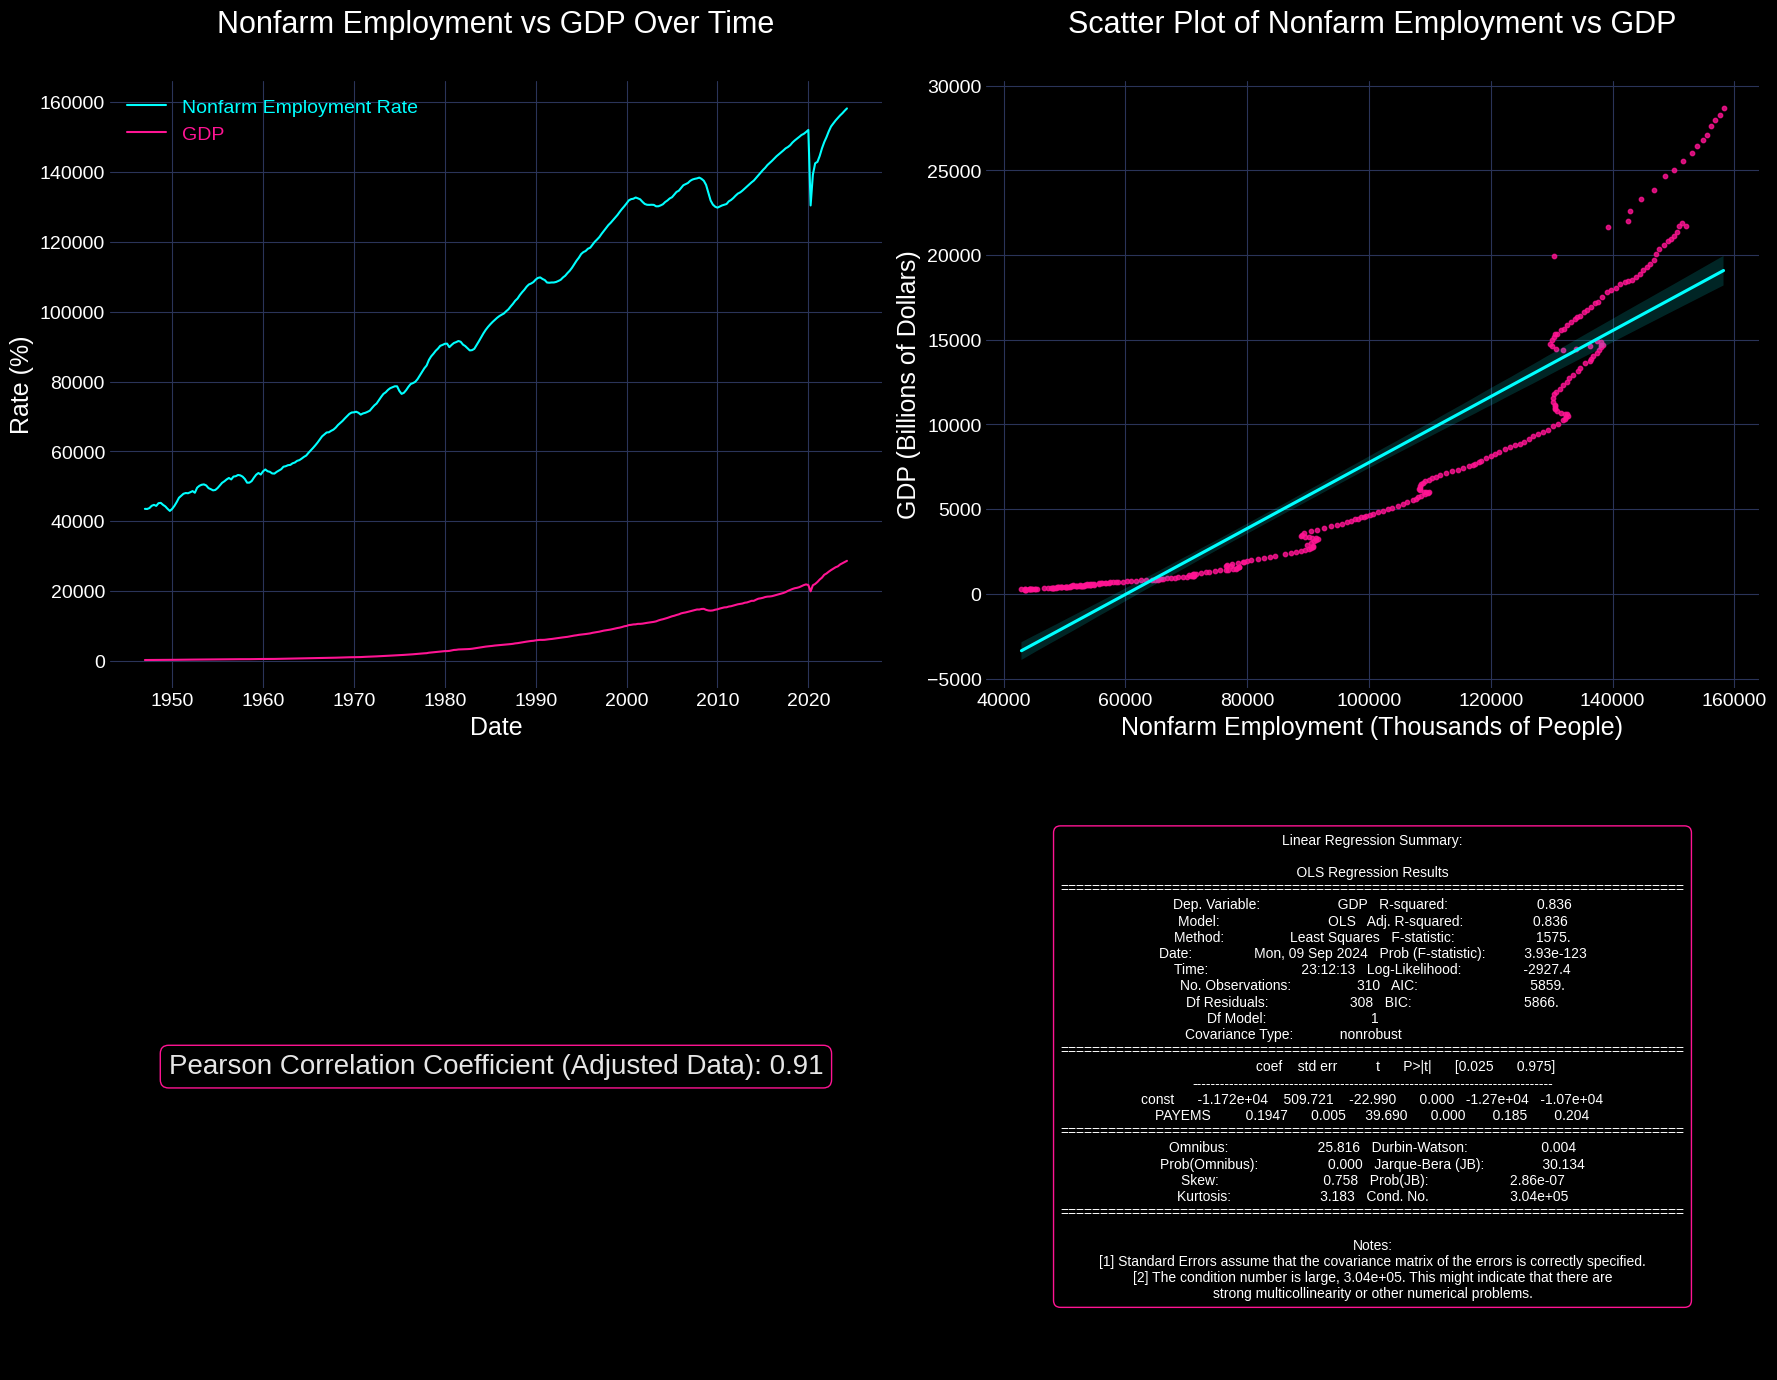

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from IPython.display import HTML
import mplcyberpunk

# Apply the Cyberpunk style for all the plots
plt.style.use("cyberpunk")

# Create a figure and axes for the dashboard
fig, axs = plt.subplots(2, 2, figsize=(18, 14), facecolor='#000000')  # Set the background to black
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot 1: Nonfarm Payroll Employment (PAYEMS) vs GDP over time
axs[0, 0].plot(merged_data['date'], merged_data['PAYEMS'], color='#00ffff', label='Nonfarm Employment Rate', zorder=3)
axs[0, 0].plot(merged_data['date'], merged_data['GDP'], color='#ff1493', label='GDP', zorder=3)
axs[0, 0].set_facecolor('#000000')  # Set plot area background to true black
axs[0, 0].set_xlabel('Date', fontsize=18, color='white')
axs[0, 0].set_ylabel('Rate (%)', fontsize=18, color='white')
axs[0, 0].tick_params(axis='both', labelsize=14, colors='white')
axs[0, 0].spines['left'].set_color('white')
axs[0, 0].spines['bottom'].set_color('white')
axs[0, 0].spines['top'].set_color('white')
axs[0, 0].spines['right'].set_color('white')
axs[0, 0].set_title('Nonfarm Employment vs GDP Over Time', fontsize=22, color='white', pad=35)
axs[0, 0].legend(loc='upper left', fontsize=14, facecolor='#181818', edgecolor='white', labelcolor=['#00ffff', '#ff1493'])

# Plot 2: Scatter Plot with Regression Line (PAYEMS vs GDP)
sns.regplot(x='PAYEMS', y='GDP', data=merged_data, ax=axs[0, 1], scatter_kws={'s': 10, 'color': '#ff1493'}, line_kws={'color': '#00ffff'})
axs[0, 1].set_facecolor('#000000')  # Set plot area background to true black
axs[0, 1].set_xlabel('Nonfarm Employment (Thousands of People)', fontsize=18, color='white')
axs[0, 1].set_ylabel('GDP (Billions of Dollars)', fontsize=18, color='white')
axs[0, 1].tick_params(axis='both', labelsize=14, colors='white')
axs[0, 1].spines['left'].set_color('white')
axs[0, 1].spines['bottom'].set_color('white')
axs[0, 1].spines['top'].set_color('white')
axs[0, 1].spines['right'].set_color('white')
axs[0, 1].set_title('Scatter Plot of Nonfarm Employment vs GDP', fontsize=22, color='white', pad=35)

# Plot 3: Display Pearson Correlation Coefficient
correlation = merged_data['PAYEMS'].corr(merged_data['GDP'])
axs[1, 0].text(0.5, 0.5, f'Pearson Correlation Coefficient (Adjusted Data): {correlation:.2f}', transform=axs[1, 0].transAxes, fontsize=20, verticalalignment='center', horizontalalignment='center', bbox=dict(boxstyle='round', facecolor='#000000', edgecolor='#ff1493'))
axs[1, 0].axis('off')

# Plot 4: Linear Regression Summary
X = merged_data['PAYEMS']
y = merged_data['GDP']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()
summary_text = model.summary().as_text()
axs[1, 1].text(0.5, 0.5, f'Linear Regression Summary:\n\n{summary_text}', transform=axs[1, 1].transAxes, fontsize=10, color='white', horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='#000000', edgecolor='#ff1493', boxstyle='round,pad=0.5'))
axs[1, 1].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the complete dashboard
mplcyberpunk.add_glow_effects()
plt.show()